# 주제 정의 및 목표 설정

주제 : 신용데이터를 통한 신용점수 모델링 및 대출가이드라인 모델링

목표 : 채무 불이행 가능성이 높은 고객을 사전에 식별할 수 있는 예측 모델을 개발합니다. 이를 통해 대출 위험을 줄이는 방안을 제시합니다.

분석 대상: 채무 불이행 위험이 높은 고객 특성 분석.

## 신용등급을 나누기 위한 가설

1. 소득과 저축 수준: Saving accounts와 Checking account의 상태가 좋을수록 신용등급이 높다.
    - 전처리 Saving accounts 와 Checking account 를 수치형 데이터로 전환 {'little': 1, 'moderate': 2, 'quite rich': 4, 'rich': 5}
    
2. 직업 안정성: Job의 등급이 높을수록(높은 소득 및 안정적인 직업군) 신용등급이 높다.

3. 주거 형태: Housing이 'own'인 경우 신용등급이 높고, 'free'나 'rent'일수록 낮다.
   - Housing 수치형 데이터 전환 {'free': 0, 'rent': 1, 'own': 2}

4. 대출 금액 대비 기간 비율: Credit amount 대비 Duration이 짧을수록 상환 능력이 뛰어나 신용등급이 높다.

5. 나이가 어릴수록 신용도가 낮을것이다.

6. 대출 목적: 대출 목적(Purpose)이 생계 필수 항목일수록 신용등급이 높다. >> 유의미함.

7. 결측치 및 불명확한 정보 비율: Saving accounts 또는 Checking account가 NA인 경우 신용등급이 낮다.

## 결측치 제거 여부 근거
- 처음에는 가설기반 신용등급 4등급으로 나누고, 결측치 제거와 최빈값대체 정확도 비교

## 머신러닝 ( 랜덤포레스트, 로지스틱회귀, 결정트리, SVM , XG부스트 )

 가설기반으로 점수 부여를 위해 각컬럼별 risk 비율 시각화- 노치훈
노치훈 -> 그래프별 색 조정 및 housing과 purpose는 수치형이 아닌 그래프로 대체

 가중치 부여한 점수 계산 후 qcut을 통해 신용등급 4등급 나누기
- 대한민국 신용도 분포와 비교한다음 , 1,2,3 등급을 좋다라고 예측

 각 컬럼별 신용등급 시각화

신용등급 과 기존 Risk 컬럼 과 비교 분석 정확도 시각화

 결론 내리기
> 결론이 좋지 않았다? 정확도를 올리기위해 어떤 방법이 있을까 ?? > 머신러닝

어떤 알고리즘을 사용할껀지 설명하는 ppt 페이지하나

 정확도 더 좋아지는 방법 없나??? >>> kfold라는 평가 기법 설명

로지스틱회귀 ~  결정트리도 했음. 평가기법 k -fold 검증 적용 크게 차이는 없엇음.

 대출 가이드라인 작성
- 우리는 ~~ 어떤 고객이 찾아왔는데 / 고객이 원하는 대출양이나 상환기간이 있다면 /  
시나리오를 짜서 보여주는 것도 괜찮다고 생각함!
- 랜덤셋[고객데이터] 신용등급 평가 후 대출 가이드라인 제시


# 0. 데이터 불러오기

In [8]:
# READ_CSV 본인 파일 위치에 맞게 설정 필요!

import os
import pandas as pd
df = pd.read_csv(f'{os.getcwd()}\data\a.csv')
df_credit = df.copy()
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


# 1. 데이터 전처리 ( 결측치 처리, 새로운 컬럼생성, 범주형 -> 수치형 )
- Saving accounts     817 non-null object
- Checking account    606 non-null object

    1. 결측치 처리 기준인 나이대 구간 컬럼 생성
    2. 결측치 처리 ( 목적, 나이대 , 주거지 , 직업별 )

In [10]:
# 필요없는 컬럼 버리기
df = df.drop('Unnamed: 0',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [12]:
import numpy as np
# Step 1: 나이대 구간 생성
bins = [18, 25, 35 , 60, 150]
labels = ['Student', 'Young', 'Adult', 'Senior']
df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels)
df['Age_group'].value_counts()
df.info()
# 결측치 처리 하지 않은것과 비교하기 위해 df1 생성
df1 = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 non-null   object  
 2   Job               1000 non-null   int64   
 3   Housing           1000 non-null   object  
 4   Saving accounts   817 non-null    object  
 5   Checking account  606 non-null    object  
 6   Credit amount     1000 non-null   int64   
 7   Duration          1000 non-null   int64   
 8   Purpose           1000 non-null   object  
 9   Risk              1000 non-null   object  
 10  Age_group         1000 non-null   category
dtypes: category(1), int64(4), object(6)
memory usage: 79.4+ KB


# 2. 결측치 처리
    - 3 deepth로 처리, Age 별 job 유무별 Housing 별 최빈값

In [16]:
#2. 결측치 처리 : Saving accounts, Checking account / 기준 : Housing , 나이대, 직업 최빈값 처리
for col in ['Saving accounts', 'Checking account']:
    # NA를 np.nan으로 변환
    df[col] = df[col].replace('NA', np.nan)
    
    # 그룹별 최빈값 계산 후 없으면 nan 반환
    mode_values = df.groupby(['Age_group', 'Job', 'Housing'], observed=False)[col].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 0)
    
    # 결측치 채우기
    for idx in df[df[col].isnull()].index:
        age_group = df.loc[idx, 'Age_group']
        job = df.loc[idx, 'Job']
        housing = df.loc[idx, 'Housing']
        if (age_group, job, housing) in mode_values.index:
            df.loc[idx, col] = mode_values.loc[(age_group, job, housing)]

# Svaing accounts 과 Checking account 의 값이 0 인 행 1개 발생

# 각 컬럼의 최빈값 계산
most_frequent_value = df['Saving accounts'].mode()[0]
most_frequent_value = df['Checking account'].mode()[0]

# Saving accounts가 0인 행의 값을 전체 데이터 최빈값으로 대체
df.loc[df['Saving accounts'] == 0, 'Saving accounts'] = most_frequent_value
df.loc[df['Checking account'] == 0, 'Checking account'] = most_frequent_value

# 결과 확인 (결과가 없어야 정상 )
print(f" 결측치가 0인 행 : {df[df['Saving accounts'] == 0]} \n\n") #Empty Data Frame 이면 정상
print(f" 결측치가 0인 행 : {df[df['Checking account'] == 0]} \n\n") #Empty Data Frame 이면 정상

df.info()

 결측치가 0인 행 : Empty DataFrame
Columns: [Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration, Purpose, Risk, Age_group]
Index: [] 


 결측치가 0인 행 : Empty DataFrame
Columns: [Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration, Purpose, Risk, Age_group]
Index: [] 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 non-null   object  
 2   Job               1000 non-null   int64   
 3   Housing           1000 non-null   object  
 4   Saving accounts   1000 non-null   object  
 5   Checking account  1000 non-null   object  
 6   Credit amount     1000 non-null   int64   
 7   Duration          1000 non-null   int64   
 8   Purpose           1000 non-null   object  
 9   Risk              1000 non-null   obj

# 3. 이상치 처리 ( 개수확인 , 시각화 ppt )

- 이상치를 확인하고, 처리여부 결정


## 이상치 개수 확인

In [13]:
# IQR을 이용한 이상치 개수와 3사분위수 출력

# IQR 계산 함수
def get_outliers_count_and_q3(column):
    Q1 = column.quantile(0.25)  # 1사분위수
    Q3 = column.quantile(0.75)  # 3사분위수
    IQR = Q3 - Q1  # IQR 계산
    lower_bound = Q1 - 1.5 * IQR  # 하한 경계
    upper_bound = Q3 + 1.5 * IQR  # 상한 경계

    # 이상치 개수 계산
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers.count(), Q3

# Credit amount의 이상치 개수와 3사분위수
credit_outliers_count, credit_q3 = get_outliers_count_and_q3(df1['Credit amount'])
print(f"Credit Amount의 상한경계 수치(Q3): {credit_q3*3}")
print(f"Credit Amount의 이상치 개수: {credit_outliers_count}")

# Duration의 이상치 개수와 3사분위수
duration_outliers_count, duration_q3 = get_outliers_count_and_q3(df1['Duration'])
print(f"Duration의 상한 경계 수치: {duration_q3*3}")
print(f"Duration의 이상치 개수: {duration_outliers_count}")


Credit Amount의 상한경계 수치(Q3): 11916.75
Credit Amount의 이상치 개수: 72
Duration의 상한 경계 수치: 72.0
Duration의 이상치 개수: 70


## 이상치 시각화 ( ppt )

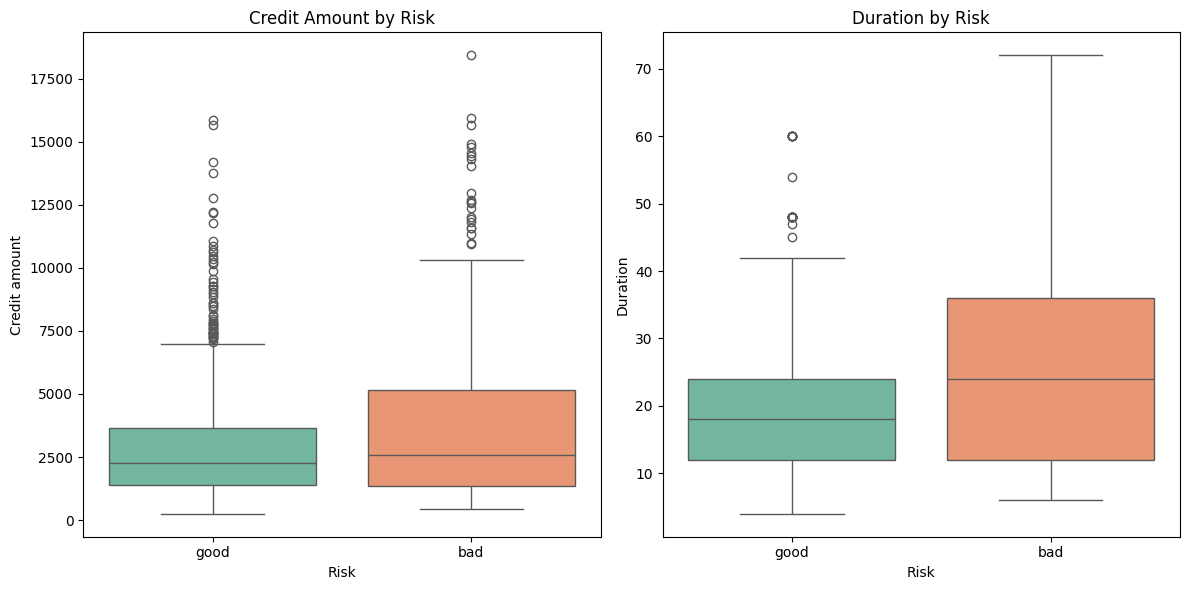

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'Credit amount'와 'Duration'에 대한 박스플롯을 'Risk'에 따라 구분
plt.figure(figsize=(12, 6))

# 'Credit amount' 박스플롯
plt.subplot(1, 2, 1)
sns.boxplot(x='Risk', y='Credit amount', data=df1, palette='Set2', hue='Risk')
plt.title('Credit Amount by Risk')

# 'Duration' 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x='Risk', y='Duration', data=df1, palette='Set2', hue='Risk')
plt.title('Duration by Risk')

plt.tight_layout()
plt.show()


# 4. 가설 검증을 위한 컬럼별 RISK 분포 시각화

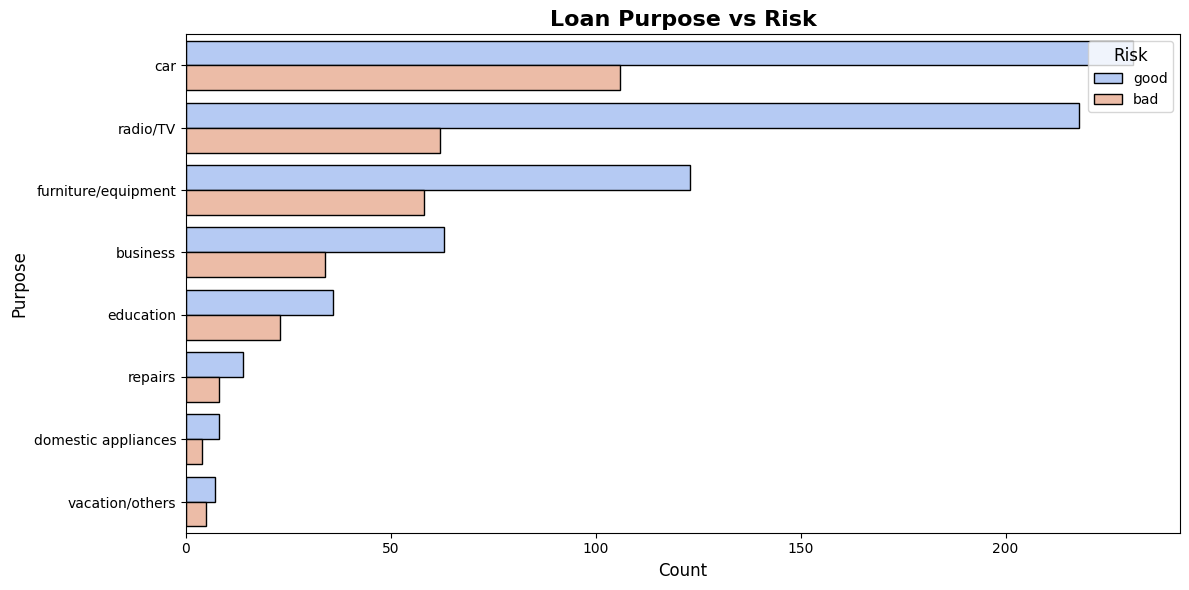

In [49]:
# 대출 목적과 위험(Risk) 관계 분석 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 조정

# 색상 팔레트 변경 및 경계선 추가
sns.countplot(
    y='Purpose',
    hue='Risk',
    data=df,
    order=df['Purpose'].value_counts().index,
    palette='coolwarm',  # 색상 팔레트 지정
    edgecolor='black'  # 막대 경계선 색상
)

# 그래프 제목, 축 라벨 및 스타일 조정
plt.title('Loan Purpose vs Risk', fontsize=16, fontweight='bold')  # 제목 설정
plt.xlabel('Count', fontsize=12)  # x축 라벨
plt.ylabel('Purpose', fontsize=12)  # y축 라벨
plt.xticks(fontsize=10)  # x축 눈금 크기
plt.yticks(fontsize=10)  # y축 눈금 크기

# 범례 스타일 변경
plt.legend(title='Risk', fontsize=10, title_fontsize=12, loc='upper right')

# 그래프 표시
plt.tight_layout()  # 그래프 요소 간격 자동 조정
plt.show()

# import plotly.express as px
# import pandas as pd

# # 데이터 준비
# df_grouped = df.groupby(['Purpose', 'Risk']).size().reset_index(name='Count')

# # Plotly Express로 막대 그래프 생성
# fig = px.bar(
#     df_grouped,
#     x='Count',  # x축: 대출 수
#     y='Purpose',  # y축: 대출 목적
#     color='Risk',  # 색상으로 Risk 구분
#     orientation='h',  # 수평 막대
#     color_discrete_sequence=px.colors.sequential.Plasma,  # 색상 팔레트
#     title='Loan Purpose vs Risk'  # 그래프 제목
# )

# # 축 및 제목 스타일 조정
# fig.update_layout(
#     title={'text': 'Loan Purpose vs Risk', 'x': 0.5, 'xanchor': 'center'},
#     xaxis_title='Count',
#     yaxis_title='Purpose',
#     font=dict(size=12),
#     legend_title='Risk',
# )

# # 축 눈금 크기 조정
# fig.update_xaxes(tickfont=dict(size=10))
# fig.update_yaxes(tickfont=dict(size=10))

# # 그래프 출력
# fig.show()


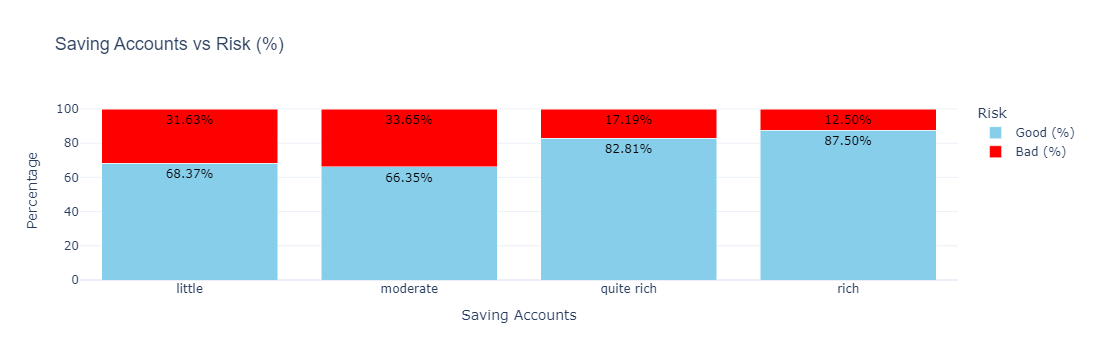

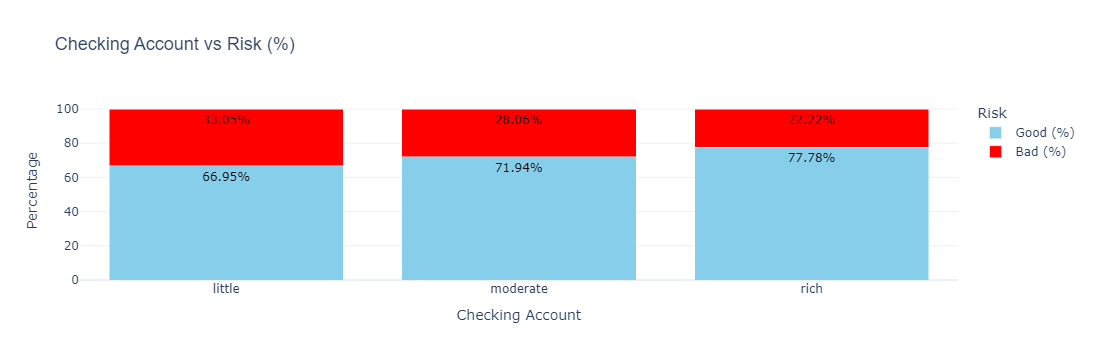

In [77]:
import plotly.express as px
import pandas as pd

# Saving accounts별 Risk 분포 계산
saving_risk_distribution = df.groupby(['Saving accounts', 'Risk'], observed=False).size().unstack(fill_value=0)

# 비율 계산
saving_risk_distribution['Total'] = saving_risk_distribution.sum(axis=1)
saving_risk_distribution['Good (%)'] = (saving_risk_distribution['good'] / saving_risk_distribution['Total']) * 100
saving_risk_distribution['Bad (%)'] = (saving_risk_distribution['bad'] / saving_risk_distribution['Total']) * 100

# 데이터프레임 형태로 변환 (Plotly에 적합한 포맷)
saving_risk_distribution_reset = saving_risk_distribution[['Good (%)', 'Bad (%)']].reset_index()
saving_risk_melted = saving_risk_distribution_reset.melt(
    id_vars='Saving accounts', value_vars=['Good (%)', 'Bad (%)'], var_name='Risk', value_name='Percentage'
)

# Plotly로 반응형 Stacked Bar Chart 생성
fig1 = px.bar(
    saving_risk_melted,
    x='Saving accounts',
    y='Percentage',
    color='Risk',
    barmode='stack',
    color_discrete_map={
        'Good (%)': 'skyblue',  # good은 하늘색
        'Bad (%)': 'red'        # bad는 빨간색
    },
    title='Saving Accounts vs Risk (%)',
    text='Percentage'  # 각 막대에 값을 표시
)

# 레이아웃 및 텍스트 위치 조정
fig1.update_traces(
    texttemplate='%{text:.2f}%',  # 소수점 두 자리까지 표시
    textposition='inside',         # 텍스트를 막대 내부에 표시
    textfont=dict(
        size=12,                  # 텍스트 크기
        color='black'             # 텍스트 색상 변경 (검정색으로 설정)
    )
)

# 전체 레이아웃 설정
fig1.update_layout(
    xaxis_title='Saving Accounts',
    yaxis_title='Percentage',
    legend_title='Risk',
    template='plotly_white',
    title_font=dict(size=18, family='Arial'),
    legend=dict(font=dict(size=12)),
    uniformtext_minsize=10,       # 텍스트 최소 크기 설정
    uniformtext_mode='hide',      # 텍스트가 겹치면 일부 숨기기
)

# Checking account별 Risk 분포 계산
checking_risk_distribution = df.groupby(['Checking account', 'Risk']).size().unstack(fill_value=0)

# 비율 계산
checking_risk_distribution['Total'] = checking_risk_distribution.sum(axis=1)
checking_risk_distribution['Good (%)'] = (checking_risk_distribution['good'] / checking_risk_distribution['Total']) * 100
checking_risk_distribution['Bad (%)'] = (checking_risk_distribution['bad'] / checking_risk_distribution['Total']) * 100

# 데이터프레임 형태로 변환 (Plotly에 적합한 포맷)
checking_risk_distribution_reset = checking_risk_distribution[['Good (%)', 'Bad (%)']].reset_index()
checking_risk_melted = checking_risk_distribution_reset.melt(
    id_vars='Checking account', value_vars=['Good (%)', 'Bad (%)'], var_name='Risk', value_name='Percentage'
)

# Plotly로 반응형 Stacked Bar Chart 생성
fig2 = px.bar(
    checking_risk_melted,
    x='Checking account',
    y='Percentage',
    color='Risk',
    barmode='stack',
    color_discrete_map={
        'Good (%)': 'skyblue',  # good은 하늘색
        'Bad (%)': 'red'        # bad는 빨간색
    },
    title='Checking Account vs Risk (%)',
    text='Percentage'  # 각 막대에 값을 표시
)

# 레이아웃 및 텍스트 위치 조정
fig2.update_traces(
    texttemplate='%{text:.2f}%',  # 소수점 두 자리까지 표시
    textposition='inside',         # 텍스트를 막대 내부에 표시
    textfont=dict(
        size=12,                  # 텍스트 크기
        color='black'             # 텍스트 색상 변경 (검정색으로 설정)
    )
)

# 전체 레이아웃 설정
fig2.update_layout(
    xaxis_title='Checking Account',
    yaxis_title='Percentage',
    legend_title='Risk',
    template='plotly_white',
    title_font=dict(size=18, family='Arial'),
    legend=dict(font=dict(size=12)),
    uniformtext_minsize=10,       # 텍스트 최소 크기 설정
    uniformtext_mode='hide',      # 텍스트가 겹치면 일부 숨기기
)

# 그래프 출력
fig1.show()
fig2.show()


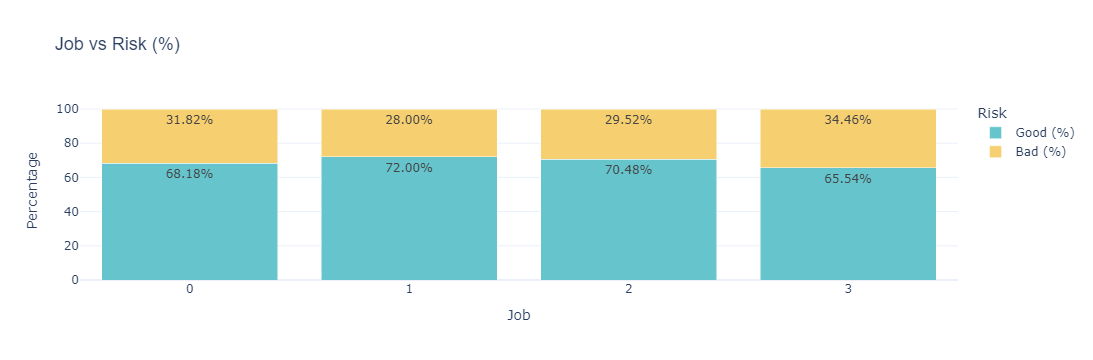

In [53]:
import plotly.express as px
import pandas as pd

# Job별 Risk 분포 계산
job_risk_distribution = df.groupby(['Job', 'Risk'], observed=False).size().unstack(fill_value=0)

# 비율 계산
job_risk_distribution['Total'] = job_risk_distribution.sum(axis=1)
job_risk_distribution['Good (%)'] = (job_risk_distribution['good'] / job_risk_distribution['Total']) * 100
job_risk_distribution['Bad (%)'] = (job_risk_distribution['bad'] / job_risk_distribution['Total']) * 100

# 데이터프레임 형태로 변환 (Plotly에 적합한 포맷)
job_risk_distribution_reset = job_risk_distribution[['Good (%)', 'Bad (%)']].reset_index()
job_risk_melted = job_risk_distribution_reset.melt(
    id_vars='Job', value_vars=['Good (%)', 'Bad (%)'], var_name='Risk', value_name='Percentage'
)

# Plotly로 반응형 Stacked Bar Chart 생성
fig = px.bar(
    job_risk_melted,
    x='Job',
    y='Percentage',
    color='Risk',
    barmode='stack',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title='Job vs Risk (%)',
    text='Percentage'  # 각 막대에 값을 표시
)

# 레이아웃 및 텍스트 위치 조정
fig.update_traces(
    texttemplate='%{text:.2f}%',  # 소수점 두 자리까지 표시
    textposition='inside'        # 텍스트를 막대 내부에 표시
)

# x축의 tick 간격을 조정하여 0.5 단위 표시 제거
fig.update_layout(
    xaxis_title='Job',
    yaxis_title='Percentage',
    legend_title='Risk',
    template='plotly_white',
    title_font=dict(size=18, family='Arial'),
    legend=dict(font=dict(size=12)),
    uniformtext_minsize=10,      # 텍스트 최소 크기 설정
    uniformtext_mode='hide',     # 텍스트가 겹치면 일부 숨기기
    xaxis=dict(
        tickmode='array',  # tick을 수동으로 설정
        tickvals=df['Job'].unique(),  # Job 값에 맞춰 tick 설정
        ticktext=df['Job'].unique(),  # 각 Job에 해당하는 값 표시
    )
)

# 그래프 출력
fig.show()


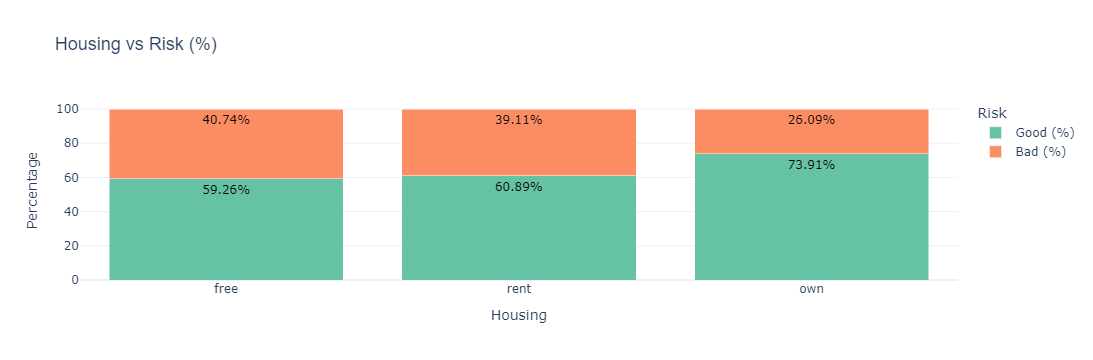

In [61]:
import plotly.express as px
import pandas as pd

# 주거지 여부별 Risk 분포 계산
saving_risk_distribution = df.groupby(['Housing', 'Risk']).size().unstack(fill_value=0)

# 비율 계산
saving_risk_distribution['Total'] = saving_risk_distribution.sum(axis=1)
saving_risk_distribution['Good (%)'] = (saving_risk_distribution['good'] / saving_risk_distribution['Total']) * 100
saving_risk_distribution['Bad (%)'] = (saving_risk_distribution['bad'] / saving_risk_distribution['Total']) * 100

# 데이터프레임 형태로 변환 (Plotly에 적합한 포맷)
saving_risk_distribution_reset = saving_risk_distribution[['Good (%)', 'Bad (%)']].reset_index()
saving_risk_melted = saving_risk_distribution_reset.melt(
    id_vars='Housing', value_vars=['Good (%)', 'Bad (%)'], var_name='Risk', value_name='Percentage'
)

# Housing 값에 대한 순서 정의 (own을 마지막으로 배치)
category_order = ['free','rent', 'own']  # 'own'을 마지막으로 배치하려면 순서 설정

# Plotly로 반응형 Stacked Bar Chart 생성
fig = px.bar(
    saving_risk_melted,
    x='Housing',
    y='Percentage',
    color='Risk',
    barmode='stack',
    color_discrete_sequence=['#66c2a5', '#fc8d62'],  # 색상 변경
    title='Housing vs Risk (%)',
    text='Percentage'  # 각 막대에 값을 표시
)

# 레이아웃 및 텍스트 위치 조정
fig.update_traces(
    texttemplate='%{text:.2f}%',  # 소수점 두 자리까지 표시
    textposition='inside',         # 텍스트를 막대 내부에 표시
    textfont=dict(
        size=12,                  # 텍스트 크기
        color='black'             # 텍스트 색상 변경 (검정색으로 설정)
    )
)

# x축을 오른쪽 끝으로 보내는 설정
fig.update_layout(
    xaxis_title='Housing',
    yaxis_title='Percentage',
    legend_title='Risk',
    template='plotly_white',
    title_font=dict(size=18, family='Arial'),
    legend=dict(font=dict(size=12)),
    uniformtext_minsize=10,       # 텍스트 최소 크기 설정
    uniformtext_mode='hide',      # 텍스트가 겹치면 일부 숨기기
    xaxis=dict(
        categoryorder='array',  # 'array'로 설정하여 항목 순서 조정
        categoryarray=category_order,  # 순서대로 정의된 항목 배열 사용
    )
)

# 그래프 출력
fig.show()


Risk            bad  good  Total   Good (%)    Bad (%)
Purpose_maping                                        
0                70   120    190  63.157895  36.842105
1               230   580    810  71.604938  28.395062


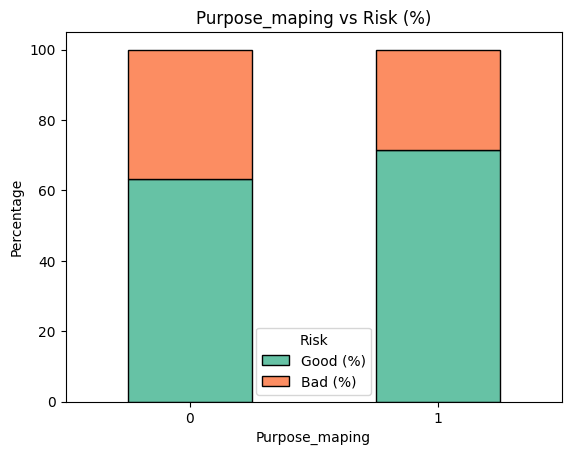

In [63]:
# 가설 3 근거 시각화 (대출 목적 분석)
# # 6. 대출 목적 분석
# # 유형자산이남는 purpose : car, radio/tv , domestic appliance , furniture/equipment
# plt.figure(figsize=(10, 5))
# sns.countplot(y='Purpose', hue='Risk', data=df, order=df['Purpose'].value_counts().index)
# plt.title('Loan Purpose vs Risk')
# plt.show()

# purpose 는 유형자산이 남는거 1, 아니면 0
purpose_mapping = {'radio/TV' : 1, 'education': 0, 'furniture/equipment': 1, 'car' : 1, 'business' : 0,
       'domestic appliances': 1, 'repairs' :0 , 'vacation/others' : 0}
df['Purpose_maping'] = df['Purpose'].map(purpose_mapping)

saving_risk_distribution = df.groupby(['Purpose_maping', 'Risk'],observed=False).size().unstack(fill_value=0)

# 비율 계산
saving_risk_distribution['Total'] = saving_risk_distribution.sum(axis=1)
saving_risk_distribution['Good (%)'] = (saving_risk_distribution['good'] / saving_risk_distribution['Total']) * 100
saving_risk_distribution['Bad (%)'] = (saving_risk_distribution['bad'] / saving_risk_distribution['Total']) * 100

print(saving_risk_distribution)

# Stacked bar chart
saving_risk_distribution[['Good (%)', 'Bad (%)']].plot(
    kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'], edgecolor='black'
)
plt.title('Purpose_maping vs Risk (%)')
plt.xlabel('Purpose_maping')
plt.xticks(rotation=0)

plt.ylabel('Percentage')
plt.legend(title='Risk')
plt.show()

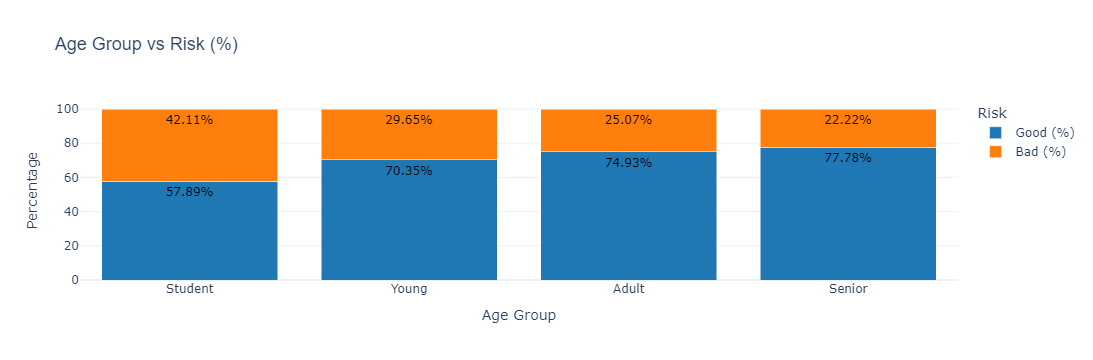

In [67]:
import plotly.express as px
import pandas as pd

# 나이대별 Risk 분포 계산
saving_risk_distribution = df.groupby(['Age_group', 'Risk'], observed=False).size().unstack(fill_value=0)

# 비율 계산
saving_risk_distribution['Total'] = saving_risk_distribution.sum(axis=1)
saving_risk_distribution['Good (%)'] = (saving_risk_distribution['good'] / saving_risk_distribution['Total']) * 100
saving_risk_distribution['Bad (%)'] = (saving_risk_distribution['bad'] / saving_risk_distribution['Total']) * 100

# 데이터프레임 형태로 변환 (Plotly에 적합한 포맷)
saving_risk_distribution_reset = saving_risk_distribution[['Good (%)', 'Bad (%)']].reset_index()
saving_risk_melted = saving_risk_distribution_reset.melt(
    id_vars='Age_group', value_vars=['Good (%)', 'Bad (%)'], var_name='Risk', value_name='Percentage'
)

# Plotly로 반응형 Stacked Bar Chart 생성
fig = px.bar(
    saving_risk_melted,
    x='Age_group',
    y='Percentage',
    color='Risk',
    barmode='stack',
    color_discrete_sequence=['#1f77b4', '#ff7f0e'],  # 파랑과 주황으로 색상 변경
    title='Age Group vs Risk (%)',
    text='Percentage'  # 각 막대에 값을 표시
)

# 레이아웃 및 텍스트 위치 조정
fig.update_traces(
    texttemplate='%{text:.2f}%',  # 소수점 두 자리까지 표시
    textposition='inside',         # 텍스트를 막대 내부에 표시
    textfont=dict(
        size=12,                  # 텍스트 크기
        color='black'             # 텍스트 색상 변경 (검정색으로 설정)
    )
)

# 전체 레이아웃 설정
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Percentage',
    legend_title='Risk',
    template='plotly_white',
    title_font=dict(size=18, family='Arial'),
    legend=dict(font=dict(size=12)),
    uniformtext_minsize=10,       # 텍스트 최소 크기 설정
    uniformtext_mode='hide',      # 텍스트가 겹치면 일부 숨기기
)

# 그래프 출력
fig.show()


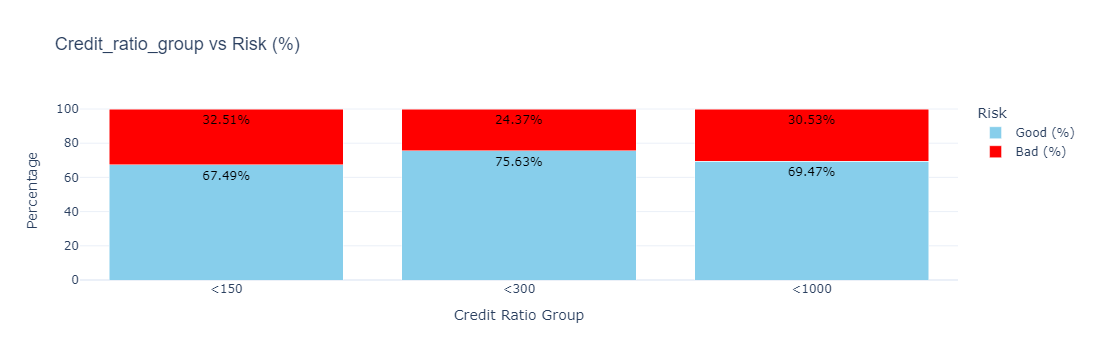

In [79]:
import plotly.express as px
import pandas as pd

# 데이터 준비
df['Credit_ratio'] = df['Credit amount'] / df['Duration']

# Step 1: 나이대 구간 생성
bins = [40, 160, 300, 1000]
labels = ['<150', '<300', '<1000']
df['Credit_ratio_group'] = pd.cut(df['Credit_ratio'], bins=bins, labels=labels)

# Credit_ratio_group과 Risk별로 계산
saving_risk_distribution = df.groupby(['Credit_ratio_group', 'Risk'], observed=False).size().unstack(fill_value=0)

# 비율 계산
saving_risk_distribution['Total'] = saving_risk_distribution.sum(axis=1)
saving_risk_distribution['Good (%)'] = (saving_risk_distribution['good'] / saving_risk_distribution['Total']) * 100
saving_risk_distribution['Bad (%)'] = (saving_risk_distribution['bad'] / saving_risk_distribution['Total']) * 100

# 데이터프레임 형태로 변환 (Plotly에 적합한 포맷)
saving_risk_distribution_reset = saving_risk_distribution[['Good (%)', 'Bad (%)']].reset_index()
saving_risk_melted = saving_risk_distribution_reset.melt(
    id_vars='Credit_ratio_group', value_vars=['Good (%)', 'Bad (%)'], var_name='Risk', value_name='Percentage'
)

# Plotly로 반응형 Stacked Bar Chart 생성
fig = px.bar(
    saving_risk_melted,
    x='Credit_ratio_group',
    y='Percentage',
    color='Risk',
    barmode='stack',
    color_discrete_map={
        'Good (%)': 'skyblue',  # good은 하늘색
        'Bad (%)': 'red'        # bad는 빨간색
    },
    title='Credit_ratio_group vs Risk (%)',
    text='Percentage'  # 각 막대에 값을 표시
)

# 레이아웃 및 텍스트 위치 조정
fig.update_traces(
    texttemplate='%{text:.2f}%',  # 소수점 두 자리까지 표시
    textposition='inside',         # 텍스트를 막대 내부에 표시
    textfont=dict(
        size=12,                  # 텍스트 크기
        color='black'             # 텍스트 색상 변경 (검정색으로 설정)
    )
)

# 전체 레이아웃 설정
fig.update_layout(
    xaxis_title='Credit Ratio Group',
    yaxis_title='Percentage',
    legend_title='Risk',
    template='plotly_white',
    title_font=dict(size=18, family='Arial'),
    legend=dict(font=dict(size=12)),
    uniformtext_minsize=10,       # 텍스트 최소 크기 설정
    uniformtext_mode='hide',      # 텍스트가 겹치면 일부 숨기기
)

# 그래프 출력
fig.show()


# 5. 상관분석을 위해 범주형 -> 수치형


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상관관계를 먼저 분석하기위해 범주형 -> 수치형

# Sex 범주형 -> 수치형
sex_mapping = {'female' : 0 , 'male': 1}
# Saving accounts와 Checking account 범주형 -> 수치형
saving_mapping = {'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}
# Housing 수치형 데이터 전환 {'free': 0, 'rent': 1, 'own': 3}
housing_mapping = {'free': 0, 'rent': 1, 'own': 5}
# purpose 는 유형자산이 남는거 1, 아니면 0
purpose_mapping = {'radio/TV' : 1, 'education': 0, 'furniture/equipment': 1, 'car' : 1, 'business' : 0,
       'domestic appliances': 1, 'repairs' :0 , 'vacation/others' : 0}
# risk bad = 0, good = 1
risk_mapping = {'bad': 0 , 'good': 1}
# age mapping 
age_mapping = {'Student': 0 , 'Young' : 1 , 'Adult' : 2, 'Senior' : 3}

df['Sex'] = df['Sex'].map(sex_mapping)
df['Saving accounts'] = df['Saving accounts'].map(saving_mapping)
df['Checking account'] = df['Checking account'].map(saving_mapping)
df['Housing'] = df['Housing'].map(housing_mapping)
df['Purpose'] = df['Purpose'].map(purpose_mapping)
df['Risk'] = df['Risk'].map(risk_mapping)
df['Age_Group_Int'] = df['Age_group'].map(age_mapping)
# 대출 금액 대비 기간 비율 계산
df['Credit_ratio'] = df['Credit amount'] / df['Duration']

# Saving accounts와 Checking account 컬럼 1개열 NULL 값을 0으로 채우기
df['Saving accounts'] = df['Saving accounts'].fillna(0)
df['Checking account'] = df['Checking account'].fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 non-null   int64   
 2   Job               1000 non-null   int64   
 3   Housing           1000 non-null   int64   
 4   Saving accounts   1000 non-null   int64   
 5   Checking account  1000 non-null   int64   
 6   Credit amount     1000 non-null   int64   
 7   Duration          1000 non-null   int64   
 8   Purpose           1000 non-null   int64   
 9   Risk              1000 non-null   int64   
 10  Age_group         1000 non-null   category
 11  Credit_ratio      1000 non-null   float64 
dtypes: category(1), float64(1), int64(10)
memory usage: 87.2 KB


# 5-1. 시각화 코드 - 상관 분석 ( corr ) 

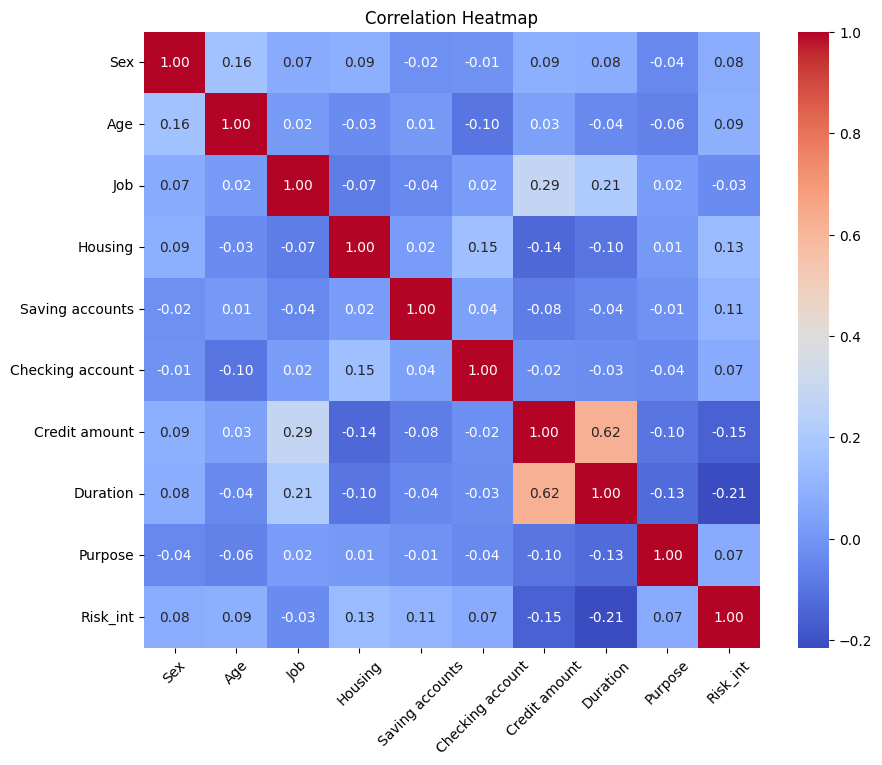

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관 행렬 계산
colleration = df[['Sex','Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration','Purpose','Risk_int']]
corr_matrix = colleration.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
# 결론 

# [TEST] 결측치 제거 여부 확인 테스트 코드
- 결측치데이터를 날려버리고, 정확도 비교를 위해 범주형 -> 수치형 매핑

- ## 한번만 실행할것!

In [116]:
# 결측치가 포함된 행 제거
df1 = df1.dropna()

df1['Sex'] = df1['Sex'].map(sex_mapping)
df1['Saving accounts'] = df1['Saving accounts'].map(saving_mapping)
df1['Checking account'] = df1['Checking account'].map(saving_mapping)
df1['Housing'] = df1['Housing'].map(housing_mapping)
df1['Purpose'] = df1['Purpose'].map(purpose_mapping)
df1['Risk_int'] = df1['Risk'].map(risk_mapping)

# 대출 금액 대비 기간 비율 계산
df1['Credit_ratio'] = df1['Credit amount'] / df1['Duration']

df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522 entries, 1 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               522 non-null    int64   
 1   Sex               522 non-null    int64   
 2   Job               522 non-null    int64   
 3   Housing           522 non-null    int64   
 4   Saving accounts   522 non-null    int64   
 5   Checking account  522 non-null    int64   
 6   Credit amount     522 non-null    int64   
 7   Duration          522 non-null    int64   
 8   Purpose           522 non-null    int64   
 9   Risk              522 non-null    object  
 10  Age_group         522 non-null    category
 11  Risk_int          522 non-null    int64   
 12  Credit_ratio      522 non-null    float64 
dtypes: category(1), float64(1), int64(10), object(1)
memory usage: 53.7+ KB


# [TEST] 결측치 제거한 데이터 신용등급 나누기
# 가설기반 점수 가중치 부여 후 q-cut 으로 등급 나누기
- ## 가중치를 반영한 비율 설정 (1등급: 10%, 2등급: 40%, 3등급: 20%, 4등급: 30%)

### MAIN (1,2,5) 실행후 실행하기

# 6. 가설기반 점수 가중치 부여 후 q-cut 으로 등급 나누기

## 가중치를 반영한 비율 설정 (1등급: 10%, 2등급: 40%, 3등급: 20%, 4등급: 30%)

In [58]:
import pandas as pd
import numpy as np

# 기준별 점수화
def calculate_score(row):
    score = 0
    # Saving accounts와 Checking account 점수
    score += row["Saving accounts"] * 10
    score += row["Checking account"] * 10
    
    # Housing 점수
    score += row["Housing"] * 3
    
    # Job 점수
    score += row["Job"] * 3
    # Purpose 점수
    score += 10 if row["Purpose"] == 1 else 0
    
    # Age_group 점수
    age_score = { "Student": 5, "Young": 10, "Adult":15 ,  "Senior": 20 }
    score += age_score[row["Age_group"]]
    
    # Credit_ratio 점수 (정규화하여 반영)
    score += row["Credit_ratio"] / 100
    
    return score

# 점수 계산
df["Score"] = df.apply(calculate_score, axis=1)

# 가중치를 반영한 비율 설정 (1등급: 10%, 2등급: 40%, 3등급: 20%, 4등급: 30%)
bins = [0, 0.3, 0.5, 0.9, 1.0]

# qcut으로 신용등급 나누기 #  시각화 ["Low", "Medium","High", "Very High"]  / ["1", "2", "3", "4"]
df['Credit_Rating'] = pd.qcut(df['Score'].rank(method='first') / len(df), q=bins, labels=["Low", "Medium","High", "Very High"])

# 결과 1. 신용도 good 인데 1등급,2등급이 맣긴하지만 low도 많다..
print(df.groupby(['Risk', 'Credit_Rating'],observed=False).size())

Risk  Credit_Rating
0     Low              128
      Medium            62
      High              92
      Very High         18
1     Low              172
      Medium           138
      High             308
      Very High         82
dtype: int64


In [60]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_group,Credit_ratio,Score,Credit_Rating
0,67,1,2,5,1,1,1169,6,1,1,Senior,194.833333,72.948333,High
1,22,0,2,5,1,2,5951,48,1,0,Student,123.979167,67.239792,Medium
2,49,1,1,5,1,1,2096,12,0,1,Adult,174.666667,54.746667,Low
3,45,1,2,0,1,1,7882,42,1,1,Adult,187.666667,52.876667,Low
4,53,1,2,0,1,1,4870,24,1,0,Adult,202.916667,53.029167,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,5,1,2,1736,12,1,1,Young,144.666667,69.446667,High
996,40,1,3,5,1,1,3857,30,1,1,Adult,128.566667,70.285667,High
997,38,1,2,5,1,1,804,12,1,1,Adult,67.000000,66.670000,Medium
998,23,1,2,0,1,1,1845,45,1,0,Student,41.000000,41.410000,Low


# [시각화] Credit_Rating 결과와 신용등급별 분포 확인 하기 (1)


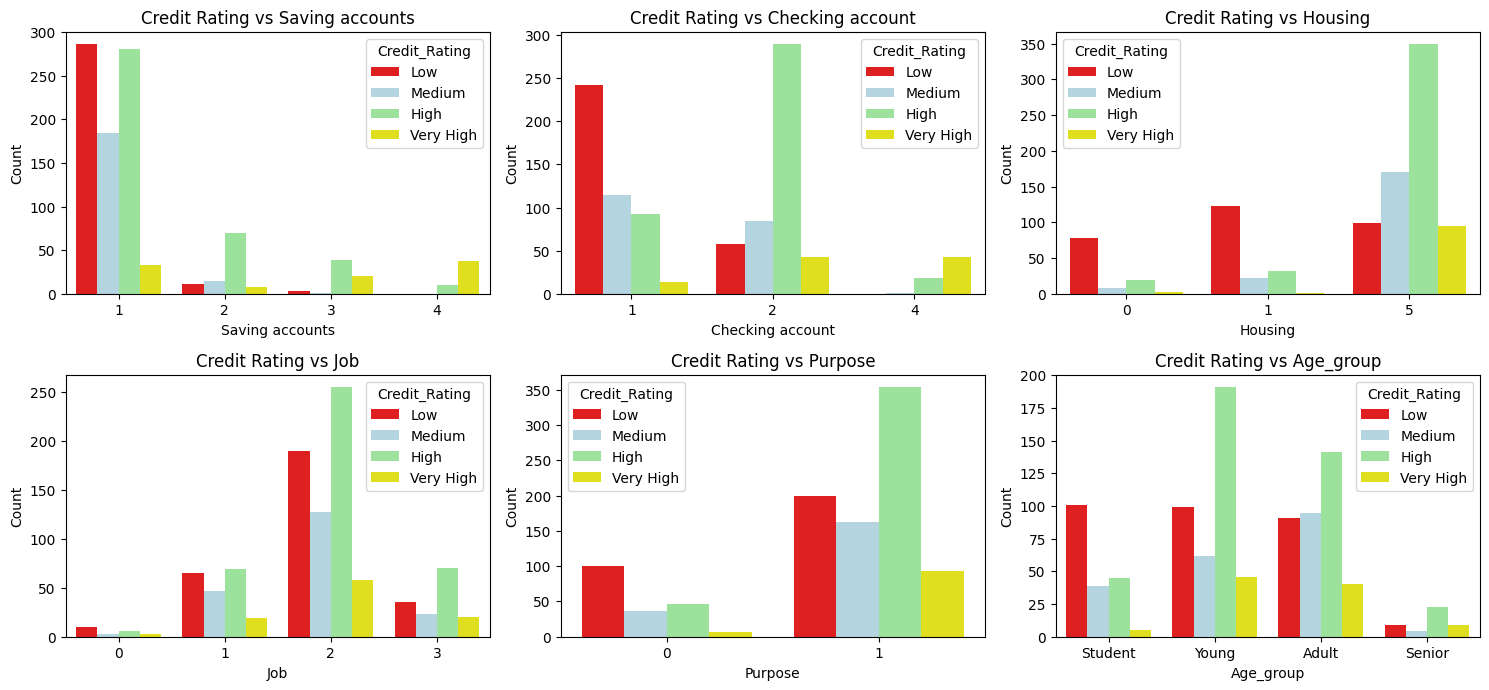

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# 각 컬럼별 Credit_Rating 분포 시각화
def visualize_credit_rating_distribution(df):
    # 리스트에 컬럼명 저장 (Credit_Rating과 관계가 있을 가능성이 있는 컬럼)
    columns_to_visualize = ["Saving accounts", "Checking account", "Housing", "Job", "Purpose", "Age_group"]

    # 플롯 설정
    plt.figure(figsize=(15, 10))
    
    # Credit_Rating을 강조할 색상 설정
    custom_palette = {
        "Low": "red",       # Low는 빨간색으로 강조
        "Medium": "lightblue",  # Medium은 파란색
        "High": "lightgreen",   # High는 초록색
        "Very High": "yellow"   # Very High는 노란색
    }
    
    for i, column in enumerate(columns_to_visualize, 1):
        plt.subplot(3, 3, i)  # 2행 4열의 서브플롯으로 나누기
        sns.countplot(data=df, x=column, hue='Credit_Rating', palette=custom_palette)  # 커스텀 색상 사용
        plt.title(f'Credit Rating vs {column}')  # 제목
        plt.xlabel(column)  # x축 레이블
        plt.ylabel('Count')  # y축 레이블

    plt.tight_layout()
    plt.show()

# 필터링된 데이터프레임 df_filtered를 사용하여 시각화 함수 호출
visualize_credit_rating_distribution(df)


# [시각화]  Credit_Rating 결과와 신용등급별 분포 확인 하기 (2)


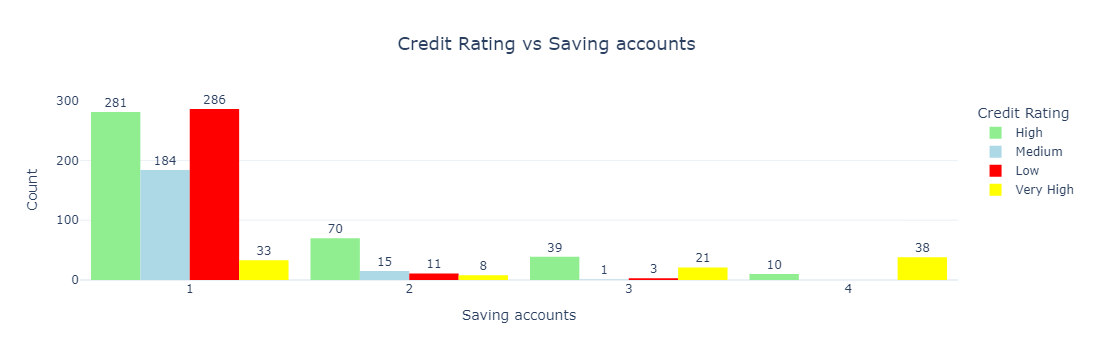

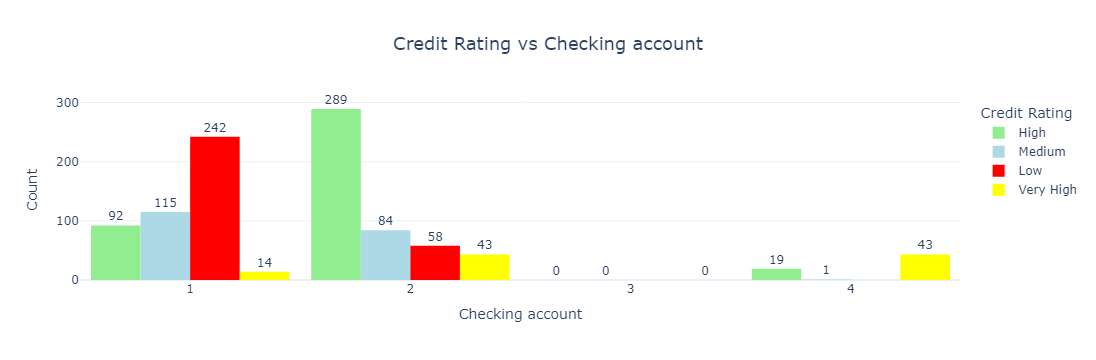

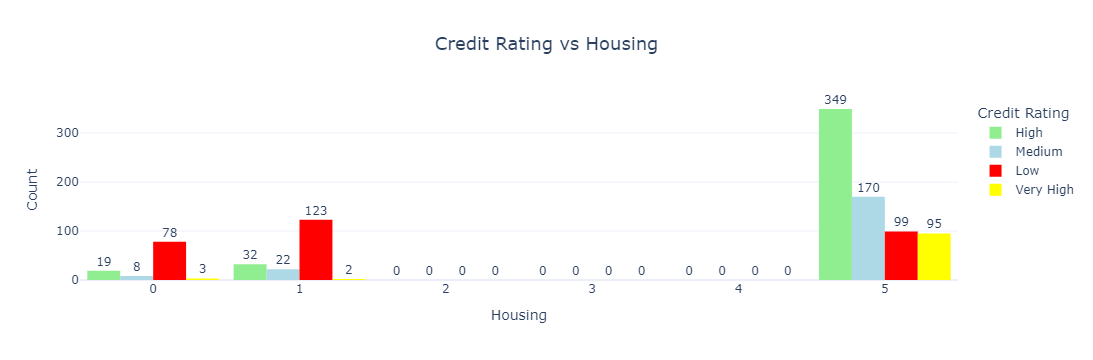

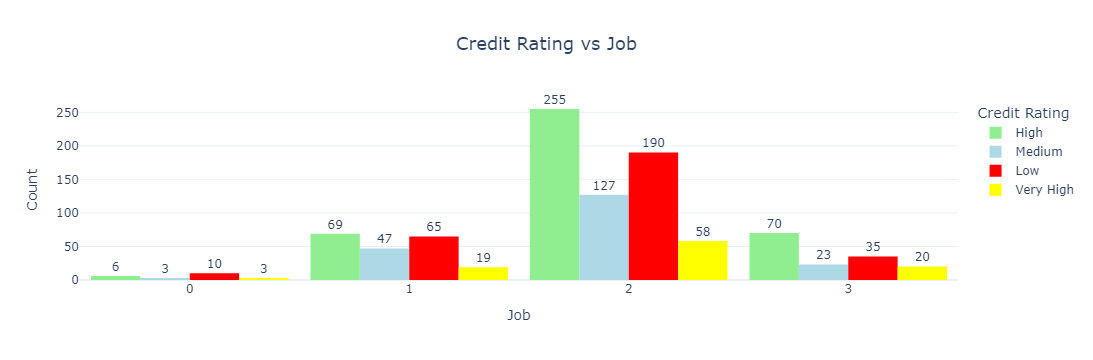

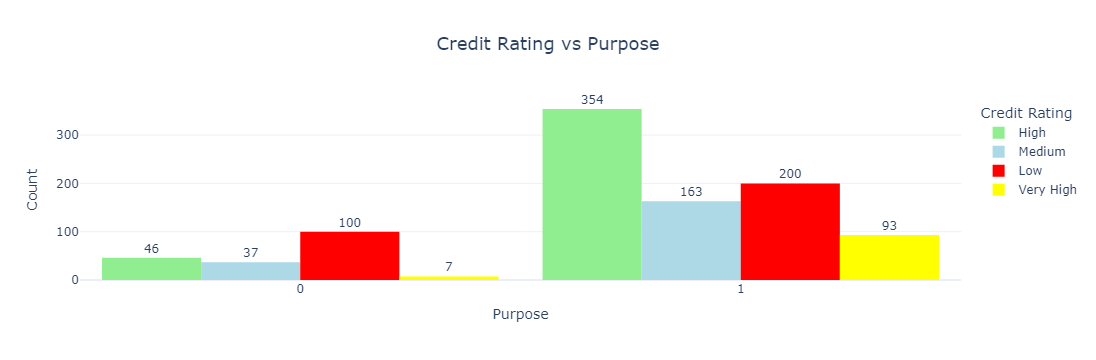

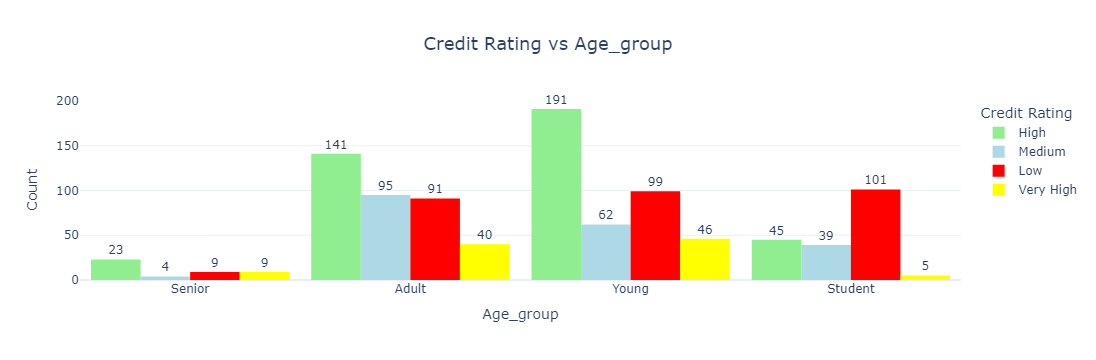

In [162]:
import plotly.express as px
import pandas as pd

# 각 컬럼별 Credit_Rating 분포 시각화 함수
def visualize_credit_rating_distribution_plotly_filtered(df):
    # 리스트에 컬럼명 저장 (Credit_Rating과 관계가 있을 가능성이 있는 컬럼)
    columns_to_visualize = ["Saving accounts", "Checking account", "Housing", "Job", "Purpose", "Age_group"]
    
    # Credit_Rating을 강조할 색상 설정
    color_map = {
        "Low": "red",       # Low는 빨간색으로 강조
        "Medium": "lightblue",  # Medium은 파란색
        "High": "lightgreen",   # High는 초록색
        "Very High": "yellow"   # Very High는 노란색
    }
    
    # 각 컬럼에 대한 시각화
    for column in columns_to_visualize:
        # X축 값이 있는 데이터만 필터링
        filtered_df = df[df[column].notna() & df[column].isin(df[column].value_counts().index)]
        
        fig = px.histogram(
            filtered_df,
            x=column,
            color='Credit_Rating',
            color_discrete_map=color_map,
            barmode='group',  # 막대를 그룹으로 배치
            text_auto=True,   # 막대 위에 수치 표시
            title=f'Credit Rating vs {column}'
        )
        
        # 레이아웃 설정
        fig.update_layout(
            xaxis_title=column,
            yaxis_title="Count",
            legend_title="Credit Rating",
            title_font_size=18,
            title_x=0.5,  # 제목 가운데 정렬
            bargap=0.1,  # 막대 간격
            template='plotly_white'  # 깔끔한 스타일
        )
        
        # 막대 위에 수치를 항상 표시
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        
        # 그래프 출력
        fig.show()

# 필터링된 데이터프레임 df를 사용하여 시각화 함수 호출
visualize_credit_rating_distribution_plotly_filtered(df)


In [187]:
# 점수 계산
df1["Score"] = df1.apply(calculate_score, axis=1)

# 가중치를 반영한 비율 설정 (1등급: 30%, 2등급: 30%, 3등급: 20%, 4등급: 20%)
bins = [0, 0.3, 0.5, 0.9, 1.0]

# qcut으로 신용등급 나누기
df1['Credit_Rating'] = pd.qcut(df1['Score'].rank(method='first') / len(df1), q=bins, labels=["Low", "Medium", "High", "Very High"])

# 결과 1. 
print(df1.groupby(['Risk', 'Credit_Rating'], observed=False).size())


Risk  Credit_Rating
bad   Low               90
      Medium            46
      High              84
      Very High         11
good  Low               67
      Medium            58
      High             124
      Very High         42
dtype: int64


# 7. 혼동행렬을 통한 신용등급 나누기 정확도 비교분석

## 시행착오
- 훈련, 테스트 데이터를 나누지 않고, 성능평가 했었음..
- 훈련 데이터 비율에 따라, 성능차이가 드라마틱함..
  

Accuracy: 0.6533
Precision: 0.7549
Recall: 0.7404
F1-score: 0.7476
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.46      0.45        46
           1       0.75      0.74      0.75       104

    accuracy                           0.65       150
   macro avg       0.60      0.60      0.60       150
weighted avg       0.66      0.65      0.66       150



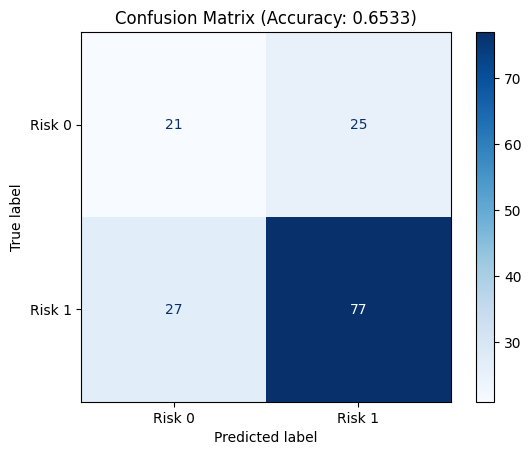

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


# 데이터 분할 (훈련 데이터와 테스트 데이터로 나누기)
# X = df[['Age_group', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Score']]
X = df
Y = df['Risk']  # 타겟 변수 (신용 위험)

# 훈련 데이터와 테스트 데이터로 70%:30% 비율로 분할
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# 실제 값과 예측 값 준비 (훈련 데이터에서 학습된 모델을 사용할 경우)
y_true = y_test  # 실제 값은 테스트 데이터의 'Risk' 컬럼
y_pred = df.loc[X_test.index, 'Credit_Rating'].map({
    "Low": 0,
    "Medium": 1,
    "High": 1,
    "Very High": 1
})  # 예측 값 (Risk 0 또는 1로 매핑)

# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)

# 결과 출력
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 상세한 평가 보고서
print("Classification Report:")
print(classification_report(y_true, y_pred))

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Risk 0", "Risk 1"]).plot(cmap='Blues')

# 시각화 설정
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.4f})")
plt.show()


# [시행착오] 결측치 제거 vs 결측치 대체(최빈값) 모델링 혼동행렬 성능비교


Accuracy: 0.6560


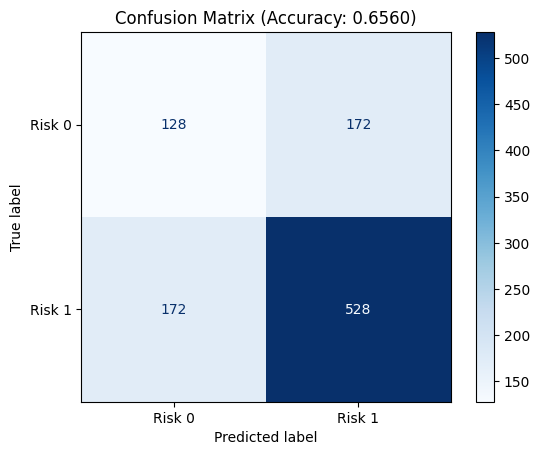

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# 실제 값과 예측 값 준비
y_true = df['Risk']  # 실제 값
y_pred = df['Credit_Rating'].map({
    "Low": 0,
    "Medium": 1, 
    "High": 1, 
    "Very High": 1
})  # 예측 값 (Risk 0 또는 1로 매핑)

# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)

# # 결과 출력
print(f"Accuracy: {accuracy:.4f}")

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Risk 0", "Risk 1"]).plot(cmap='Blues')

# 시각화 설정
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.4f})")
plt.show()


# 1. (모델링) 랜덤 포레스트 (분류모델)

## - 특성별 중요도 시각화
### - 모델링한 SCORE 특성 및 CREDIT RATING 학습 전 vs 학습 후 비교 분석
###
- 랜덤포레스트는 범주형데이터를 바로 학습시키지 못함. 범주형 -> 수치형 필요

Accuracy: 0.66
Precision: 0.74
Recall: 0.79
F1-score: 0.76
Confusion Matrix:
[[ 32  59]
 [ 43 166]]


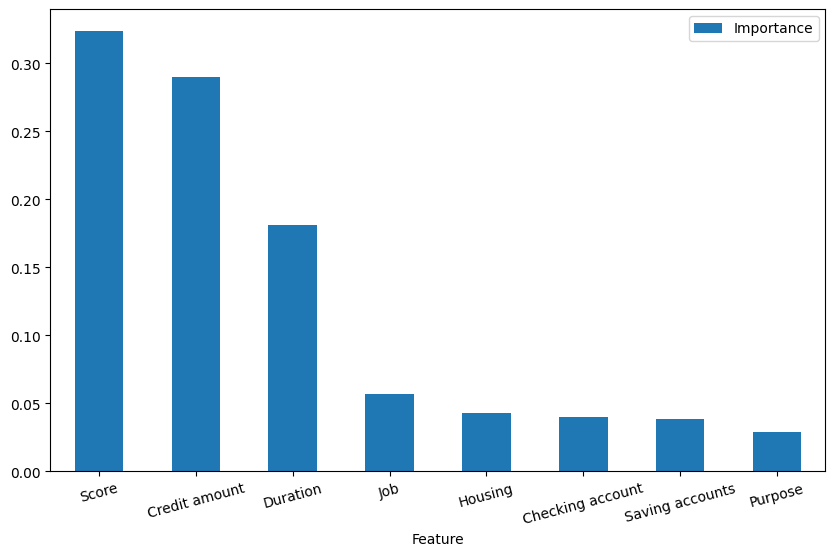

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.35      0.39        91
           1       0.74      0.79      0.76       209

    accuracy                           0.66       300
   macro avg       0.58      0.57      0.58       300
weighted avg       0.64      0.66      0.65       300



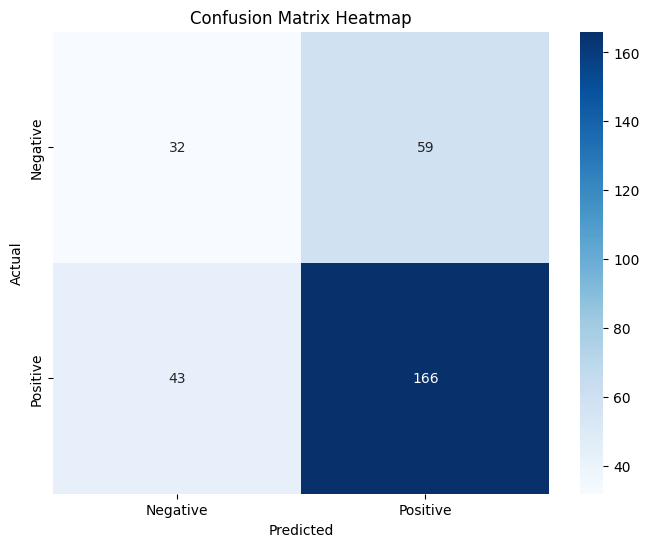

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split  # train_test_split 임포트
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 준비 (df가 이미 준비되어 있다고 가정)
# X = 특성, y = 타겟 변수
X = df[['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose','Score']]
y = df['Risk']  # 타겟 변수 (신용 위험)

# 데이터 분리 : 훈련 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# RandomForest 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 예측 수행
y_pred = model.predict(X_test)

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # 이진 분류일 경우 'binary' 추가
recall = recall_score(y_test, y_pred, average='binary')  # 'binary' 추가
f1 = f1_score(y_test, y_pred, average='binary')  # 'binary' 추가

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# 특성 중요도 추출
feature_importances = model.feature_importances_

# 중요도를 시각화
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.xticks(rotation=15)
plt.show()

# 상세한 평가 보고서
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬을 히트맵으로 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 2. (모델링 ) XG 부스트
## - 특설별 중요도 시각화 ( Score 학습 전 vs 학습 후 )

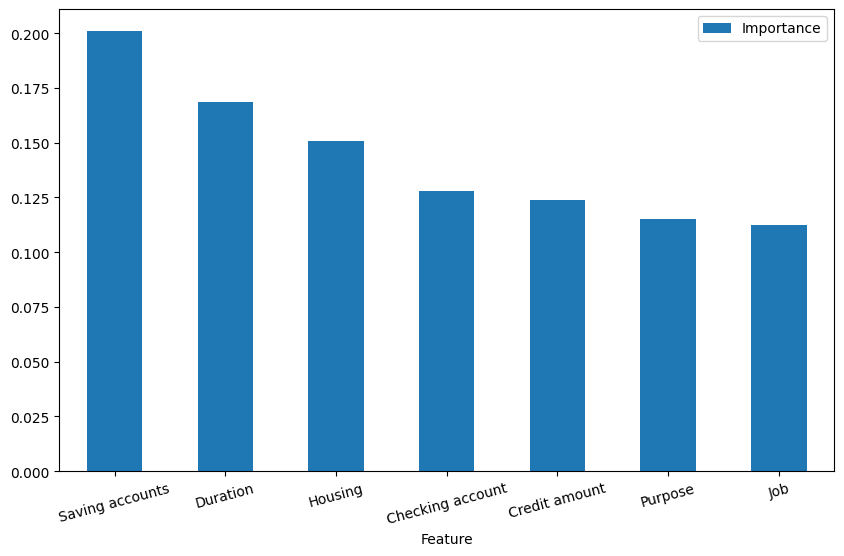

Accuracy: 0.65
Precision: 0.73
Recall: 0.80
F1-score: 0.76
Confusion Matrix:
[[ 28  63]
 [ 41 168]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.31      0.35        91
           1       0.73      0.80      0.76       209

    accuracy                           0.65       300
   macro avg       0.57      0.56      0.56       300
weighted avg       0.63      0.65      0.64       300



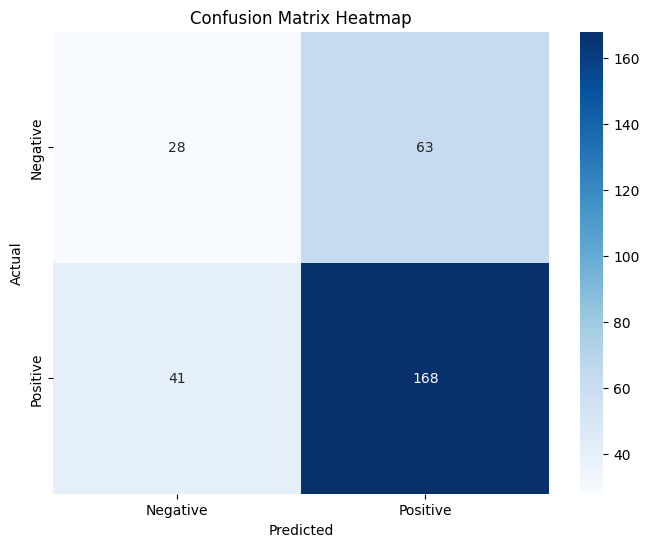

In [115]:
import xgboost as xgb

# XG 부스트 모델 학습
# 데이터 분리 ('Risk'가 타겟 변수일 경우)
X = df[['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']]
y = df['Risk']  # 타겟 변수 (신용 위험)

# 데이터 분리 : 데이터를 훈련 데이터와 테스트 세트로 나누기 # X는 특성(독립 변수), y는 타겟(종속 변수)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 학습
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# 특성 중요도 추출
feature_importances = model.feature_importances_

# 중요도를 시각화
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.xticks(rotation=15)

plt.show()

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# 상세한 평가 보고서
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬을 히트맵으로 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. 로지스틱회귀 모델 학습 및 정확도 시각화

C:\Users\clgns\anaconda3\envs\fastcampus\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



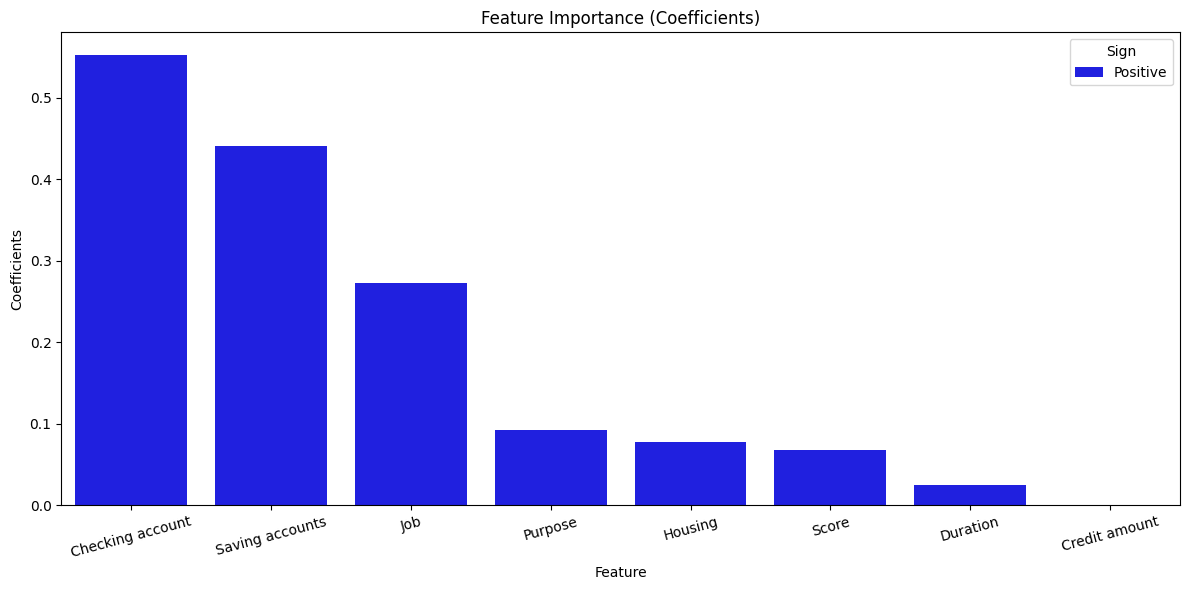

Accuracy: 0.70
Precision: 0.72
Recall: 0.93
F1-score: 0.81
Confusion Matrix:
[[ 16  75]
 [ 15 194]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.18      0.26        91
           1       0.72      0.93      0.81       209

    accuracy                           0.70       300
   macro avg       0.62      0.55      0.54       300
weighted avg       0.66      0.70      0.65       300



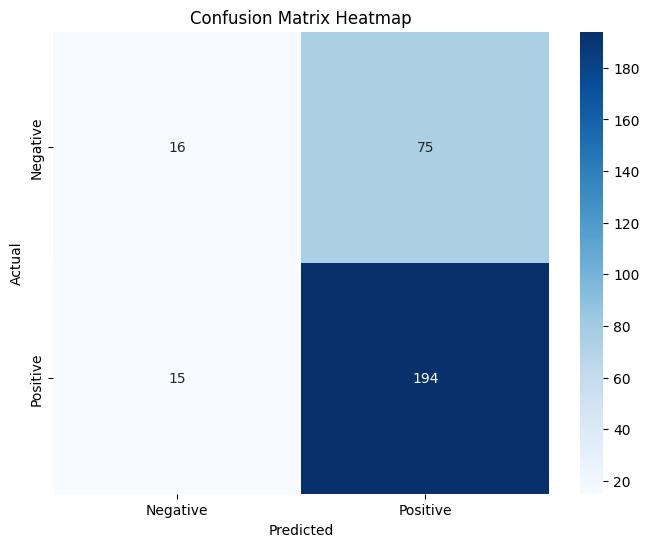

In [195]:
# 로지스틱 회귀

# 필요한 라이브러리 임포트
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 데이터 분리 ('Risk'가 타겟 변수일 경우)
X = df[['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose','Score']]
y = df['Risk']  # 타겟 변수 (신용 위험)

# 데이터 분리 : 데이터를 훈련 데이터와 테스트 세트로 나누기 # X는 특성(독립 변수), y는 타겟(종속 변수)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 생성
model = LogisticRegression()

# 모델 훈련 # 훈련 데이터를 사용하여 모델을 훈련
model.fit(X_train, y_train)

# 가중치 추출
feature_importances = np.abs(model.coef_[0])  # 절댓값으로 중요도 계산

# 중요도를 데이터프레임으로 정리
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비
importances_df = importances_df.rename(columns={'Importance': 'Coefficients'})  # 컬럼 이름 변경

# Coefficients의 양수/음수 여부에 따라 hue 값 설정
importances_df['Sign'] = importances_df['Coefficients'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=importances_df,
    x='Feature',
    y='Coefficients',
    hue='Sign',  # Positive와 Negative를 기준으로 색상 구분
    palette={'Positive': 'blue', 'Negative': 'red'}
)

# 그래프 설정
plt.xticks(rotation=15)
plt.title("Feature Importance (Coefficients)")
plt.xlabel("Feature")
plt.ylabel("Coefficients")
plt.tight_layout()
plt.legend(title="Sign")
plt.show()

# 예측 수행
y_pred = model.predict(X_test)

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# 상세한 평가 보고서
print("Classification Report:")
print(classification_report(y_test, y_pred))
# 혼동 행렬을 히트맵으로 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 그라디언트 부스팅 모델 학습 및 혼동행렬로 정화도 시각화 (1) 
### 분석할 주요 수치형 컬럼 선택

# 4. 그라디언트 부스팅 ( = 결정트리 모델 반복 ) 모델 학습 및 혼동행렬로 정확도 시각화 (2)

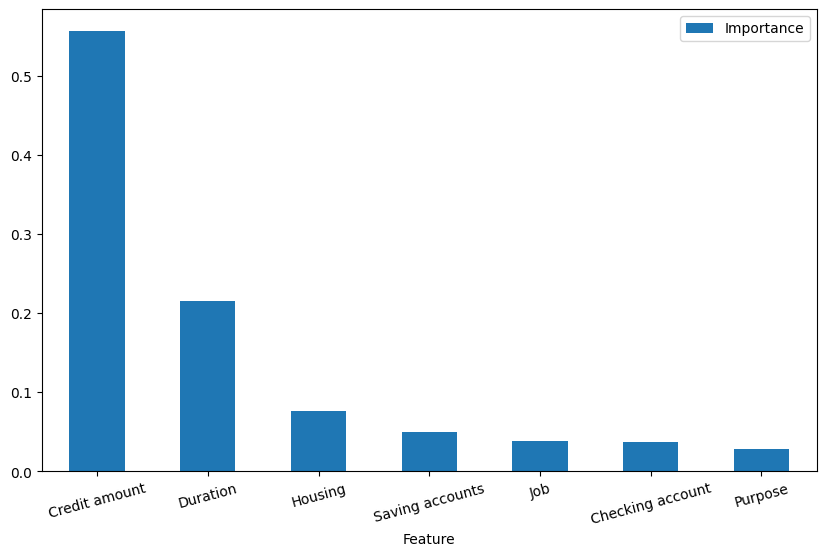

Gradient Boosting Classifier Accuracy on Test Data: 0.6733333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.18      0.25        91
           1       0.71      0.89      0.79       209

    accuracy                           0.67       300
   macro avg       0.56      0.53      0.52       300
weighted avg       0.62      0.67      0.63       300



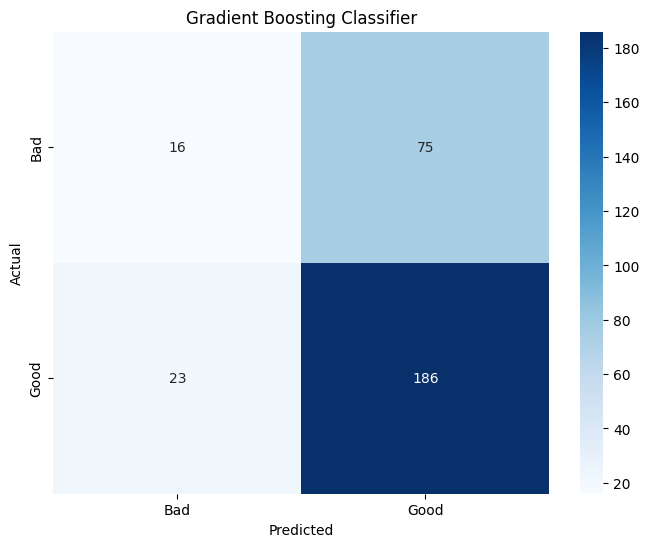

In [223]:
# 그라디언트 부스팅 적용 코드:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 주요 수치형 컬럼 선택 및 가중치 설정
columns_to_use = ['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration','Purpose']

# 데이터 준비
X = df[columns_to_use]  # 특성 변수들
y = df['Risk']  # 목표 변수: 'Risk' (신용등급)

# 데이터 분할 (훈련 데이터와 테스트 데이터로 나누기)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 그라디언트 부스팅 모델 생성
gb_model = GradientBoostingClassifier(random_state=42)

# 그라디언트 부스팅 모델 학습
gb_model.fit(X_train, y_train)

# 특성 중요도 추출
feature_importances = gb_model.feature_importances_

# 중요도를 시각화
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.xticks(rotation=15)

plt.show()

# 테스트 데이터에 대한 예측 수행
y_pred = gb_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Gradient Boosting Classifier Accuracy on Test Data:", accuracy)

# 상세한 평가 보고서

from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# 혼동 행렬 계산

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Gradient Boosting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4-1. 하이퍼 피라미터 튜닝 코드 추가해보기¶
## 트리의 최대 깊이, 최소 샘플 수 등의 파라미터 값 최적화하는 과정이라고하는데, 잘 이해하지 못했음

In [509]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# 주요 수치형 컬럼 선택 및 가중치 설정
columns_to_use = ['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration','Purpose','Credit_Rating']

# 데이터 준비
X = df[columns_to_use]  # 특성 변수들
y = df['Risk']  # 목표 변수: 'Risk' (신용등급)

# 그라디언트 부스팅 모델 생성
model = GradientBoostingClassifier(random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 150],        # 트리의 개수
    'learning_rate': [0.01, 0.1, 0.2],     # 학습률
    'max_depth': [3, 4, 5],                # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],       # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]          # 리프 노드의 최소 샘플 수
}

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# GridSearchCV 실행
grid_search.fit(X, y)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
cross_val_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# 교차 검증 결과 출력
print("K-Fold Cross Validation Scores with Best Model:", cross_val_scores)
print("Mean Accuracy from K-Fold Cross Validation with Best Model:", cross_val_scores.mean())

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
K-Fold Cross Validation Scores with Best Model: [0.76  0.7   0.705 0.695 0.7  ]
Mean Accuracy from K-Fold Cross Validation with Best Model: 0.712


# 5. (모델링) SVM 특성분포 중요도 및 정확도 비교

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# 주요 수치형 컬럼 선택 및 가중치 설정
columns_to_use = ['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose'] 

# 데이터 준비
X = pd.get_dummies(df[columns_to_use], drop_first=True)  # 범주형 변수 원-핫 인코딩
y = df['Risk']  # 목표 변수: 'Risk' (신용등급)

# 데이터 분할 (훈련 데이터와 테스트 데이터로 나누기)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SVM 모델 생성 (RBF 커널 사용)
svm_model = SVC(kernel='linear', random_state=42, probability=True)

# 선형 커널을 사용하는 SVC 모델 학습
svm_model.fit(X_train, y_train)


# 특성 중요도 추출
feature_importances = np.abs(svm_model.coef_[0])  # 각 특성의 중요도 (가중치 절댓값)

# 중요도를 시각화
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.xticks(rotation=15)
plt.show()


# 테스트 데이터에 대한 예측 수행
y_pred = svm_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("SVM Classifier Accuracy on Test Data:", accuracy)

# 상세한 평가 보고서
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("SVM Classifier Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 여러 분류기법 정확도 비교 시각화 (1)

In [475]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# 데이터 준비 (df는 결측치 대체한 기존 데이터프레임)
# # 'Credit_Rating'을 수치화하여 모델 학습에 사용 / 사용안해도됌!
# df['Credit_Rating'] = LabelEncoder().fit_transform(df['Credit_Rating'])


# 특성 (features)과 목표 변수 (target) 정의
X = df[['Score', 'Saving accounts', 'Checking account', 'Housing', 'Job', 'Purpose', 'Age_group', 'Credit_ratio','Credit_Rating']]
y = df['Risk']

# 범주형 변수 처리 (Age_group, Job, Purpose 등)
X = pd.get_dummies(X, drop_first=True)

# 훈련 데이터와 테스트 데이터로 분할 ( 테스트 0.3 )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 분류 모델들 생성
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# 모델 학습 및 정확도 평가
accuracy_results = {}

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

for model_name, model in models.items():
    model.fit(X_train, y_train)  # 모델 훈련
    y_pred = model.predict(X_test)  # 예측
    accuracy = accuracy_score(y_test, y_pred)  # 정확도 계산
    accuracy_results[model_name] = accuracy

# 정확도 비교
print("Model Accuracy Comparison:")
for model_name, accuracy in accuracy_results.items():
    print(f"{model_name}: {accuracy:.4f}")


Model Accuracy Comparison:
Random Forest: 0.6767
Logistic Regression: 0.6967
Decision Tree: 0.6433


C:\Users\clgns\anaconda3\envs\fastcampus\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# 랜덤포레스트 , XGBoost, 로지스틱 선형회기, 결정트리, SVM  정확도 비교 시각화
    
- k-fold 방식을 적용 했을 때 vs 안했을때 시각화 ppt 추가하기
- k-fold 비교기법은 주석처리가능함

Model Accuracy with K-Fold Cross Validation:
Random Forest: 0.6510
Logistic Regression: 0.7070
Decision Tree: 0.6130
SVM: 0.7020
KNN: 0.6410
XGBoost: 0.6530


C:\Users\clgns\AppData\Local\Temp\ipykernel_10264\2843007913.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




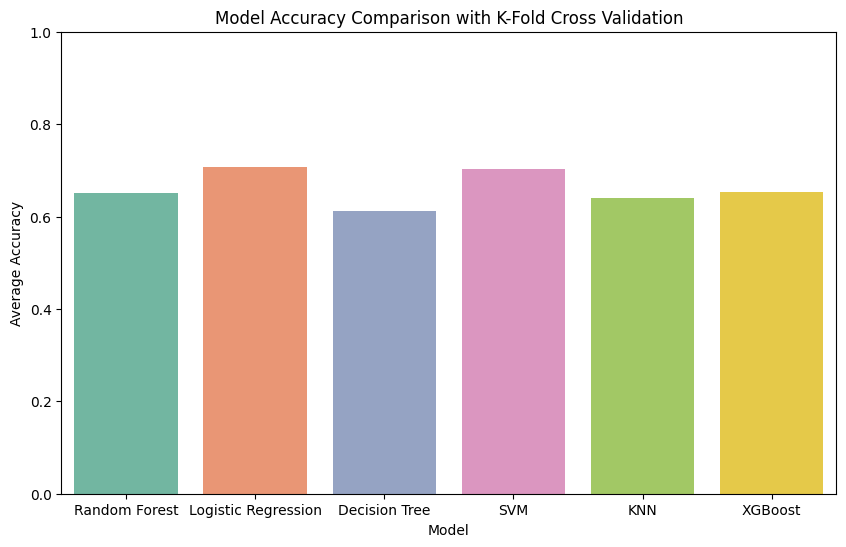

In [533]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# # 특성 (features)과 목표 변수 (target) 정의
X = df[['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration','Purpose']]
y = df['Risk']

# # 데이터 분할 (훈련 데이터와 테스트 데이터로 나누기)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 정의
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# K-fold 교차 검증 설정
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증을 통한 각 모델의 평균 정확도 계산
accuracy_results = {}

for model_name, model in models.items():
    # 각 모델에 대해 K-fold 교차 검증 실행
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    accuracy_results[model_name] = np.mean(scores)  # 평균 정확도 저장

# 결과 출력
print("Model Accuracy with K-Fold Cross Validation:")
for model_name, accuracy in accuracy_results.items():
    print(f"{model_name}: {accuracy:.4f}")

# 시각화: 모델별 평균 정확도 비교
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), palette="Set2",legend=False)
plt.title('Model Accuracy Comparison with K-Fold Cross Validation')
plt.xlabel('Model')
plt.ylabel('Average Accuracy')
plt.ylim(0, 1)
plt.show()
